## Notebook that pulls together known subject and sample covariates cleans up as neccessary and writes to single file 

In [1]:
!date

Tue Aug  3 22:49:15 UTC 2021


#### import libraries and set notebook variables

In [2]:
import pandas as pd
import ppscore as pps
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [3]:
# parameter variables
cohort = 'foundin'
quant_type = 'scrn'

# directories 
wrk_dir = f'/home/jupyter/sceqtl'
info_dir = f'{wrk_dir}/sample_info'

# input files
src_info_bckt_path = 'gs://foundin-processed-assay/analysis/integration/sample_info'
subject_info_file = f'{src_info_bckt_path}/amppd_demographicsPlus_2019_v1release_1015.csv'
cell_info_file = f'{src_info_bckt_path}/cell_metadata.csv'
genos_pca_file = f'{src_info_bckt_path}/foundin.freeze9.pca.eigenvec'
assay_metrics_file = 'gs://foundin-processed-assay/analysis/scrn_eqtl/COVARIATES_BATCH.txt'
subj_overview_file = f'{src_info_bckt_path}/Expanded_overview_of_included_PPMI_samples_overview.csv'
subj_grs_file = f'{src_info_bckt_path}/Expanded_overview_of_included_PPMI_samples_GRS.csv'

# output files
assay_covs_files = f'{info_dir}/{cohort}_{quant_type}_sample_info.csv'

# constants
max_cov_missing_rate = 0.5
repeated_id_dict = {'PPMI3966B1': 'PPMI3966', 'PPMI3966B2': 'PPMI3966', 
                    'PPMI3966B3': 'PPMI3966', 'PPMI3966B5': 'PPMI3966'}

#### load cell line info

In [4]:
cell_info = pd.read_csv(cell_info_file)
print(cell_info.shape)
# add 'PPMI' to patno
cell_info['PPMI_ID'] = 'PPMI' + cell_info['PPMI_ID'].astype(str)
# display(cell_info.sample(10))

(101, 15)


#### load subject info file, from AMP-PD, and merge with cell info

In [5]:
subj_info = pd.read_csv(subject_info_file)
subj_info['wgsid'] = subj_info['participant_id']
subj_info['participant_id'] = subj_info['participant_id'].str.replace('PP-', 'PPMI')
print(subj_info.shape)
# display(subj_info.head())

# now merge cell and subject info
info_df = pd.merge(cell_info, subj_info, how='left', left_on='PPMI_ID', right_on='participant_id')
print(info_df.shape)
# display(info_df.head())

(4298, 17)
(101, 32)


#### load the FOUNDIN subject overiew files and merge

In [6]:
overview_df = pd.read_csv(subj_overview_file)
overview_df['PPMI_ID'] = 'PPMI' + overview_df['PATNO'].astype(str)
print(overview_df.shape)
# display(overview_df.head())

(135, 24)


In [7]:
grs_df = pd.read_csv(subj_grs_file)
grs_df['PPMI_ID'] = grs_df['IID'].str.replace('PPMISI', 'PPMI')
print(grs_df.shape)
# display(grs_df.head())

(127, 13)


In [8]:
# these originated from same file, think they have duplicated columns
print(set(overview_df.columns) & set(grs_df.columns))
display(overview_df.info())
display(grs_df.info())

{'PPMI_ID', 'IID', 'exclude', 'RECRUITMENT_CAT', 'DESCRP_CAT'}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PATNO            135 non-null    int64  
 1   RECRUIT          135 non-null    object 
 2   YEARSEDUC        135 non-null    int64  
 3   FAMILY_HISTORY   134 non-null    float64
 4   DX_INIT          135 non-null    object 
 5   DIAG             135 non-null    object 
 6   AGE_enroll       135 non-null    float64
 7   AGE_ONSET        73 non-null     float64
 8   BIRTHDT          135 non-null    int64  
 9   RECRUITMENT_CAT  135 non-null    object 
 10  IMAGING_CAT      135 non-null    object 
 11  ENROLL_CAT       135 non-null    object 
 12  DESCRP_CAT       83 non-null     object 
 13  genetic_sex      134 non-null    float64
 14  pheno            135 non-null    object 
 15  Barcode_LNG      135 non-null    object 
 16 

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FID              127 non-null    object 
 1   IID              127 non-null    object 
 2   RECRUITMENT_CAT  127 non-null    object 
 3   DESCRP_CAT       80 non-null     object 
 4   PHENO            127 non-null    int64  
 5   CNT              127 non-null    int64  
 6   CNT2             127 non-null    int64  
 7   SCORE            127 non-null    float64
 8   SCORE_no_GBA     127 non-null    float64
 9   exclude          13 non-null     object 
 10  NOTE             4 non-null      object 
 11  GROUP            127 non-null    object 
 12  PPMI_ID          127 non-null    object 
dtypes: float64(2), int64(3), object(8)
memory usage: 13.0+ KB


None

In [9]:
cols_to_drop = ['RECRUITMENT_CAT', 'exclude', 'DESCRP_CAT', 'IID', 'IID', 
                'PHENO', 'NOTE']
grs_df.drop(columns=cols_to_drop, inplace=True)

In [10]:
# couple of the categoricals look like they have decent amount of missing
check_these_columns = ['DESCRP_CAT', 'mutation', 'Relatives', 'exclude']

for this_col in check_these_columns:
    print(this_col)
    print(overview_df[this_col].value_counts())

DESCRP_CAT
LRRK2+    37
GBA+      34
HYP        5
SNCA+      4
RBD        3
Name: DESCRP_CAT, dtype: int64
mutation
LRRK2_G2019S              35
GBA_N409S                 33
SNCA_A53T                  4
LRRK2_G2019S_GBA_N409S     2
LRRK2_Arg1441Gly           1
Name: mutation, dtype: int64
Relatives
first_degree_with_50860    1
first_degree_with_50219    1
first_degree_with_50184    1
first_degree_with_40273    1
first_degree_with_52787    1
first_degree_with_52783    1
first_degree_with_53340    1
first_degree_with_53339    1
first_degree_with_54265    1
first_degree_with_54262    1
first_degree_with_57170    1
first_degree_with_56169    1
Name: Relatives, dtype: int64
exclude
YES, ancestry                           6
relative_exclude                        5
YES, not 100% concordance               3
YES, not PD                             2
YES, ancestry + not 100% concordance    1
YES, no genome                          1
Name: exclude, dtype: int64


In [11]:
# so those missing can be filled with None category instead of missing
for this_col in check_these_columns:
    overview_df[this_col].fillna('None', inplace=True)

In [12]:
# merge overview and grs
overview_df = overview_df.merge(grs_df, how='left', on='PPMI_ID')
print(overview_df.shape)
# display(overview_df.sample(5))

(135, 30)


In [13]:
# merge with large info
info_df = info_df.merge(overview_df, how='left', on='PPMI_ID')
print(info_df.shape)
# display(info_df.sample(5))

(101, 61)


#### load and merge in the genetics PCs

In [14]:
genetic_components_df = pd.read_csv(genos_pca_file, sep='\s+', index_col=1)
genetic_components_df.drop(columns=['#FID'], inplace=True)
print(genetic_components_df.shape)

# merge genetics PCs with other info
info_df = info_df.merge(genetic_components_df, how='left', left_on='wgsid', right_index=True)
print(info_df.shape)
# display(info_df.head())

(133, 20)
(101, 81)


#### load the sample assays metrics info

In [ ]:
# load the sample QC info
metrics_info = pd.read_csv(assay_metrics_file, sep='\t', index_col=0).transpose()
cols_to_keep = ['Estimated.Number.of.Cells', 'Mean.Reads.per.Cell', 
                'Total.Genes.Detected', 'Median.UMI.Counts.per.Cell']
metrics_info = metrics_info[cols_to_keep]
print(metrics_info.shape)
# display(metrics_info.head())

#### now merge the assay QC/metrics with rest of info by assay's sample id

In [ ]:
info_df = info_df.merge(metrics_info, how='left', left_on='PPMI_ID', right_index=True)
print(info_df.shape)
# display(info_df.head())

#### check the dtypes and fix as neccessary

In [26]:
pd.set_option('display.max_rows', None)
# display(info_df.dtypes)
display(info_df.info())
pd.reset_option('display.max_rows')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 100
Data columns (total 85 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Batch                           101 non-null    object 
 1   PPMI_ID                         101 non-null    object 
 2   DZNE_Barcode                    101 non-null    object 
 3   DZNE_ID                         101 non-null    object 
 4   Culture_Media_iPSC              101 non-null    object 
 5   Growth_iPSC                     101 non-null    object 
 6   Spontaneous_differentiation     101 non-null    object 
 7   Mychoplasma_Test                101 non-null    object 
 8   Differentiation_Start           101 non-null    object 
 9   TH_SCRN                         82 non-null     float64
 10  MAP2_SCRN                       82 non-null     float64
 11  TH_Pel-Freez_ICC                97 non-null     float64
 12  MAP2_Santa_Cruz_ICC             97 n

None

#### get rid of the columns that have single values or a lot missingness

In [27]:
cols_to_drop = []
for this_col in info_df.columns:
    drop_col = False
    try:
        percent_miss = info_df[this_col].isna().sum()/info_df.shape[0]
        if percent_miss > max_cov_missing_rate:
            drop_col = True
        else:
            total_unique = len(info_df[this_col].unique())
            if total_unique == 1 or (total_unique == info_df.shape[0] 
                                     and info_df[this_col].dtype == 'object'):
                drop_col = True
    except:
        drop_col = True

    if drop_col:
        cols_to_drop.append(this_col)

        
print(cols_to_drop)

['Mychoplasma_Test', 'GUID', 'ethnicity_y', 'exclude']


In [28]:
info_df['ethnicity_y'].value_counts()

European    101
Name: ethnicity_y, dtype: int64

In [29]:
# fix those assay metrics colnames that have preceeding spaces
cols_new_names = {'Estimated.Number.of.Cells': 'EstimatedNumberofCells',
                  'Mean.Reads.per.Cell': 'MeanReadsperCell',
                  'Total.Genes.Detected': 'TotalGenesDetected',
                  'Median.UMI.Counts.per.Cell': 'MedianUMICountsperCell'}
info_df.rename(columns=cols_new_names, inplace=True)

In [ ]:
# see if sample without WGS is still there, ie won't have genetic PCs computed
info_df.loc[info_df['wgsid'].isna()]

In [ ]:
# which samples are missing cell fractions
print(info_df.loc[info_df['EstimatedNumberofCells'].isna()].shape)
display(info_df.loc[info_df['EstimatedNumberofCells'].isna()])
print(info_df.loc[info_df['EstimatedNumberofCells'].isna()].index)

#### if those columns look useless drop

In [33]:
info_df.drop(columns=cols_to_drop, inplace=True)
print(info_df.shape)

(101, 81)


#### save the complete covariates file

In [34]:
info_df.to_csv(assay_covs_files)

#### take a look to see how corrlated or predictive covariates are and visualize

#### use Predictive Power Score to see what is associated with items of interest

In [43]:
# check other cell type related covariates for ther predictorsTH_SCRN
covs_of_interest = ['TH_SCRN', 'MAP2_SCRN']
other_covs = []
for this_cov in covs_of_interest:
    print(this_cov)
    predictors_df = pps.predictors(info_df, this_cov)
    # drop anything that has ppscore of zero
    predictors_df = predictors_df.loc[predictors_df['ppscore'] > 0]
    display(predictors_df)
    other_covs.extend(predictors_df['x'].tolist())
    
print(other_covs)

TH_SCRN


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,TH_Pel-Freez_ICC,TH_SCRN,0.178253,regression,True,mean absolute error,5.052500,4.151875,DecisionTreeRegressor()
1,Batch,TH_SCRN,0.168500,regression,True,mean absolute error,5.054878,4.203132,DecisionTreeRegressor()
2,Differentiation_Start,TH_SCRN,0.151817,regression,True,mean absolute error,5.054878,4.287460,DecisionTreeRegressor()
3,TH_Millipore_ICC,TH_SCRN,0.058140,regression,True,mean absolute error,5.052500,4.758750,DecisionTreeRegressor()
4,Barcode_LNG,TH_SCRN,0.042355,regression,True,mean absolute error,5.054878,4.840778,DecisionTreeRegressor()
5,Barcode_DZNE,TH_SCRN,0.042355,regression,True,mean absolute error,5.054878,4.840778,DecisionTreeRegressor()
6,Alternate MRN,TH_SCRN,0.040000,regression,True,mean absolute error,5.054878,4.852683,DecisionTreeRegressor()


MAP2_SCRN


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,MAP2_Santa_Cruz_ICC,MAP2_SCRN,0.243275,regression,True,mean absolute error,9.107500,6.891875,DecisionTreeRegressor()
1,Culture_Media_iPSC,MAP2_SCRN,0.018686,regression,True,mean absolute error,9.035366,8.866531,DecisionTreeRegressor()
2,FAMILY_HISTORY,MAP2_SCRN,0.008662,regression,True,mean absolute error,9.035366,8.957099,DecisionTreeRegressor()
3,Differentiation_Start,MAP2_SCRN,0.001276,regression,True,mean absolute error,9.035366,9.023835,DecisionTreeRegressor()
4,Batch,MAP2_SCRN,0.000217,regression,True,mean absolute error,9.035366,9.033405,DecisionTreeRegressor()


['TH_Pel-Freez_ICC', 'Batch', 'Differentiation_Start', 'TH_Millipore_ICC', 'Barcode_LNG', 'Barcode_DZNE', 'Alternate MRN', 'MAP2_Santa_Cruz_ICC', 'Culture_Media_iPSC', 'FAMILY_HISTORY', 'Differentiation_Start', 'Batch']


In [ ]:
matrix_df = pps.matrix(info_df[list(set(covs_of_interest) | set(other_covs))])
matrix_df = matrix_df.loc[matrix_df['ppscore'] > 0]
print(matrix_df.shape)

matrix_df['ppscore'] = matrix_df['ppscore'].round(2)
plot_matrix_df = matrix_df[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
print(plot_matrix_df.shape)
display(plot_matrix_df)

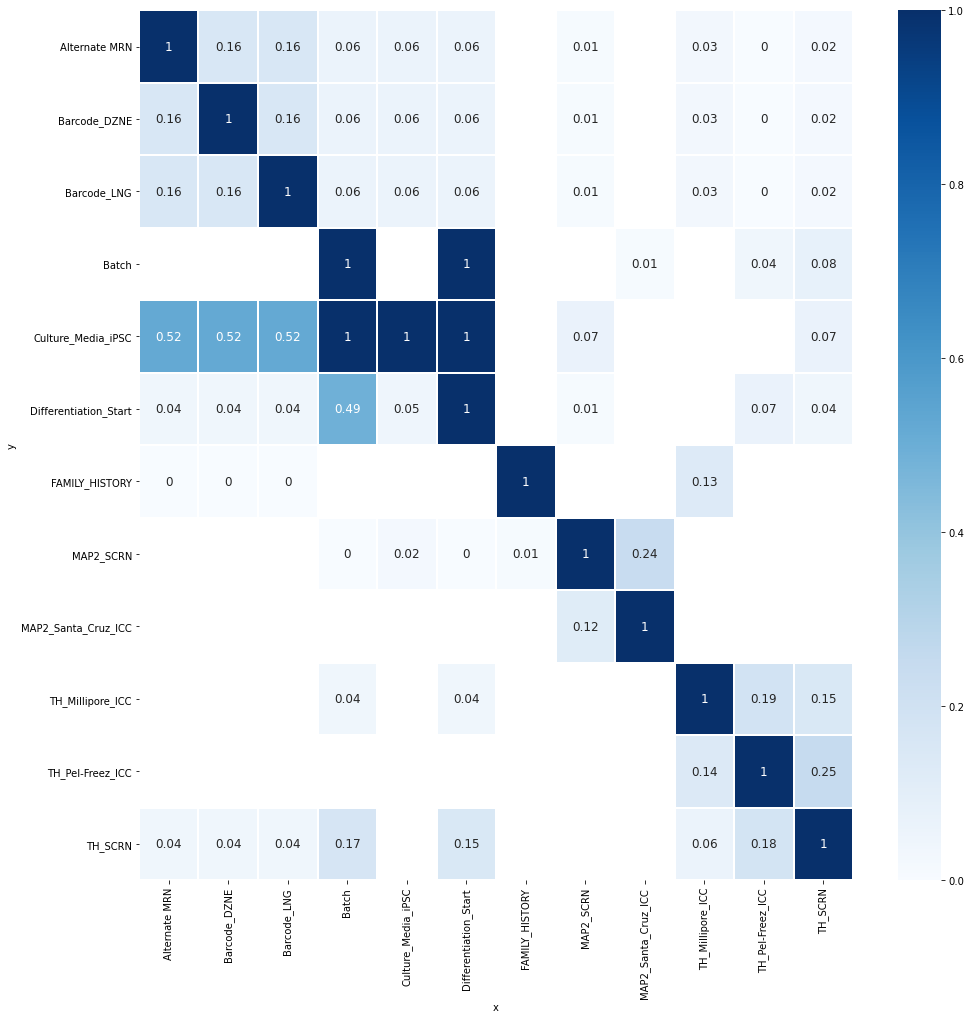

In [45]:
plt.figure(figsize=(16,16)) 
sns.heatmap(plot_matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.05, 
            annot=True, annot_kws={"fontsize":12})
plt.show()

In [46]:
temp_df = info_df[list(set(covs_of_interest) | set(other_covs))]
cats_df = temp_df.select_dtypes(include=['object'])
print(cats_df.shape)
dums_df = pd.get_dummies(cats_df)
print(dums_df.shape)

covs_df = temp_df.merge(dums_df, how='inner', left_index=True, right_index=True)
print(covs_df.shape)

(101, 6)
(101, 265)
(101, 277)


(271, 271)


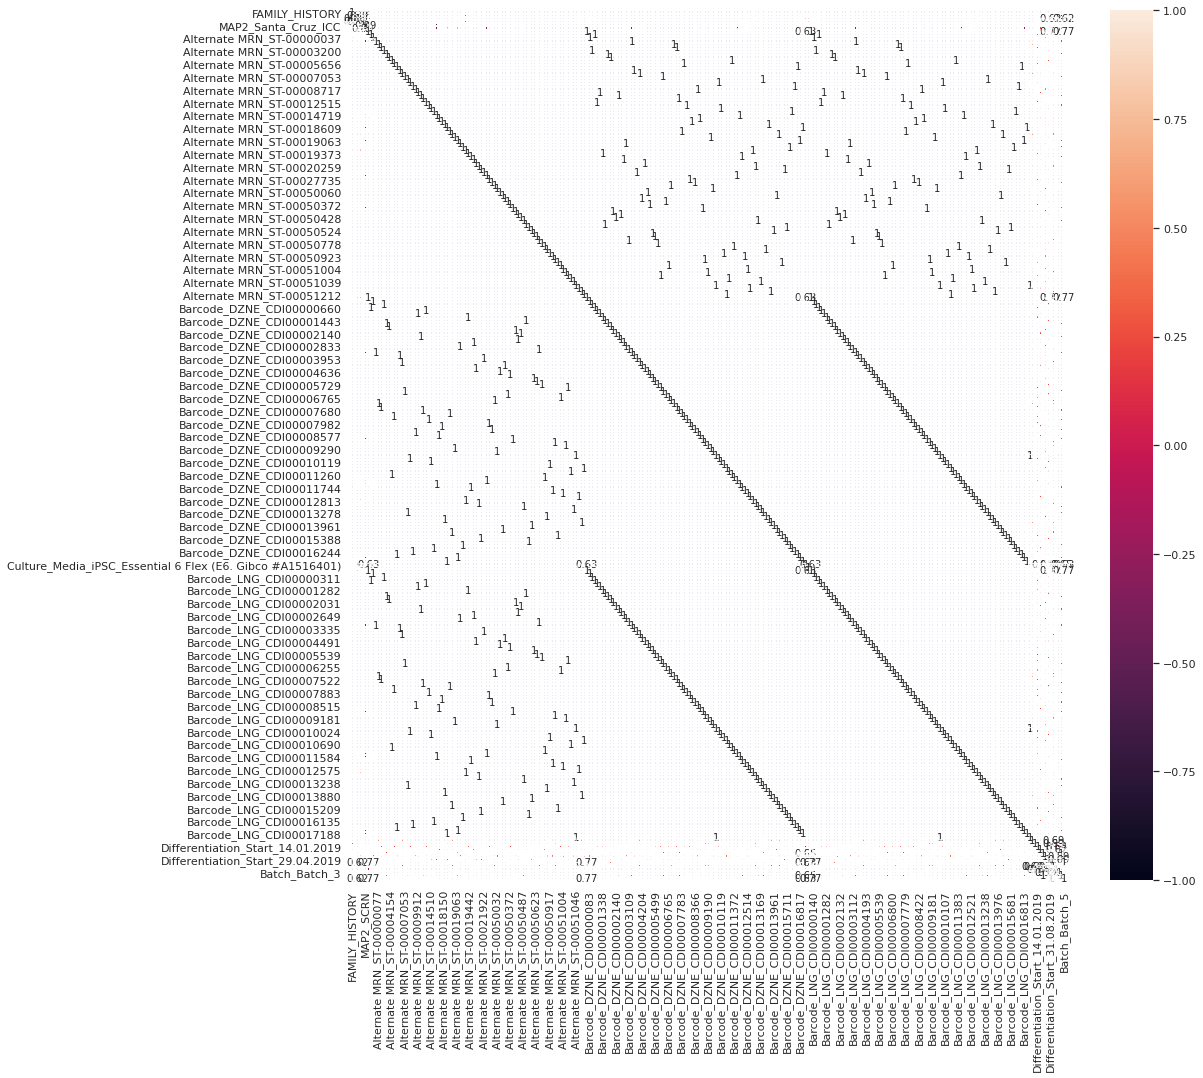

In [47]:
sns.set()
cor = covs_df.corr(method='pearson')
cor.dropna(how='all', inplace=True)
print(cor.shape)
plt.figure(figsize=(16,16))        
sns.heatmap(cor[(cor > 0.22) | (cor < -0.22)], annot=True, annot_kws={"fontsize":10}, \
            linewidths=0.05)    
plt.show()

In [48]:
# a lot of warning can be generated related to number of members and n_splits=4
# so temp supress warnings
warnings.filterwarnings('ignore')

matrix_df = pps.matrix(info_df)
matrix_df = matrix_df.loc[matrix_df['ppscore'] > 0]
print(matrix_df.shape)

default_max_rows = pd.get_option('display.max_rows')
pd.set_option('display.max_rows', 100)
display(matrix_df)
pd.set_option('display.max_rows', default_max_rows)

# restore defaults warning setting
# warnings.filterwarnings('default')
warnings.filterwarnings('once')

(2330, 9)


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,Batch,Batch,1.000000,predict_itself,True,None,0.000000,1.000000,None
4,Batch,Culture_Media_iPSC,1.000000,classification,True,weighted F1,0.584158,1.000000,DecisionTreeClassifier()
5,Batch,Growth_iPSC,0.210421,classification,True,weighted F1,0.741390,0.795807,DecisionTreeClassifier()
6,Batch,Spontaneous_differentiation,0.002254,classification,True,weighted F1,0.811357,0.811783,DecisionTreeClassifier()
7,Batch,Differentiation_Start,0.492574,classification,True,weighted F1,0.118812,0.552862,DecisionTreeClassifier()
...,...,...,...,...,...,...,...,...,...
6528,MedianUMICountsperCell,IID,0.045960,classification,True,weighted F1,0.012346,0.057738,DecisionTreeClassifier()
6531,MedianUMICountsperCell,FID,0.045960,classification,True,weighted F1,0.012346,0.057738,DecisionTreeClassifier()
6557,MedianUMICountsperCell,EstimatedNumberofCells,0.215321,regression,True,mean absolute error,1525.098765,1196.713095,DecisionTreeRegressor()
6558,MedianUMICountsperCell,MeanReadsperCell,0.689134,regression,True,mean absolute error,16482.753086,5123.924405,DecisionTreeRegressor()


In [49]:
matrix_df['ppscore'] = matrix_df['ppscore'].round(2)
plot_matrix_df = matrix_df[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
print(plot_matrix_df.shape)
display(plot_matrix_df)

(81, 81)


x,AGE_ONSET,AGE_enroll,Alternate MRN,BIRTHDT,Barcode_DZNE,Barcode_LNG,Batch,CNT,CNT2,Culture_Media_iPSC,...,mutation,participant_id,pheno,prodromal_category,race,sex,study_arm,visit_month,visit_name,wgsid
y,,,,,,,,,,,,,,,,,,,,,
AGE_ONSET,1.00,0.74,NaN,0.73,NaN,NaN,0.03,NaN,NaN,NaN,...,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AGE_enroll,0.71,1.00,NaN,0.65,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alternate MRN,0.01,0.07,1.00,NaN,0.16,0.16,0.06,NaN,0.01,0.06,...,0.03,0.05,NaN,0.0,NaN,NaN,0.05,NaN,NaN,0.05
BIRTHDT,0.72,0.61,0.02,1.00,0.02,0.02,NaN,NaN,NaN,NaN,...,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01
Barcode_DZNE,0.01,0.07,0.16,NaN,1.00,0.16,0.06,NaN,0.01,0.06,...,0.03,0.05,NaN,0.0,NaN,NaN,0.05,NaN,NaN,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sex,NaN,NaN,0.02,0.00,0.02,0.02,NaN,NaN,NaN,NaN,...,0.01,NaN,0.22,NaN,NaN,1.00,0.31,NaN,NaN,NaN
study_arm,0.11,0.07,0.14,0.13,0.14,0.14,0.05,0.01,NaN,NaN,...,0.36,0.02,0.37,NaN,NaN,0.15,1.00,NaN,NaN,0.02
visit_month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [50]:
# plt.figure(figsize=(24,20)) 
# sns.heatmap(plot_matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.05, 
#             annot=True, annot_kws={"fontsize":10})
# plt.show()

In [51]:
info_df.select_dtypes(include=['object']).columns

Index(['Batch', 'PPMI_ID', 'DZNE_Barcode', 'DZNE_ID', 'Culture_Media_iPSC',
       'Growth_iPSC', 'Spontaneous_differentiation', 'Differentiation_Start',
       'participant_id', 'visit_name', 'sex', 'ethnicity_x', 'race',
       'education_level_years', 'diagnosis_at_baseline', 'diagnosis_latest',
       'case_control_other_at_baseline', 'case_control_other_latest',
       'study_arm', 'prodromal_category', 'Recruitment', 'wgsid', 'RECRUIT',
       'DX_INIT', 'DIAG', 'RECRUITMENT_CAT', 'IMAGING_CAT', 'ENROLL_CAT',
       'DESCRP_CAT', 'pheno', 'Barcode_LNG', 'Barcode_DZNE', 'Alternate MRN',
       'IID', 'mutation', 'Relatives', 'FID', 'GROUP'],
      dtype='object')

In [53]:
# cats_df = info_df.select_dtypes(include=['object'])
cats_df = info_df[['Batch', 'Culture_Media_iPSC', 'Growth_iPSC',
                   'Spontaneous_differentiation', 'Differentiation_Start',
                   'visit_name', 'sex', 'ethnicity_x', 'race',
                   'education_level_years', 'diagnosis_at_baseline', 
                   'diagnosis_latest', 'case_control_other_at_baseline', 
                   'case_control_other_latest', 'study_arm', 'prodromal_category', 
                   'Recruitment', 'RECRUIT', 'DX_INIT', 'DIAG', 'RECRUITMENT_CAT', 
                   'IMAGING_CAT', 'ENROLL_CAT', 'DESCRP_CAT', 'pheno',
                   'mutation', 'Relatives', 'GROUP']]
print(cats_df.shape)
dums_df = pd.get_dummies(cats_df)
print(dums_df.shape)

covs_df = info_df.merge(dums_df, how='inner', left_index=True, right_index=True)
print(covs_df.shape)

(101, 28)
(101, 139)
(101, 220)


(181, 182)


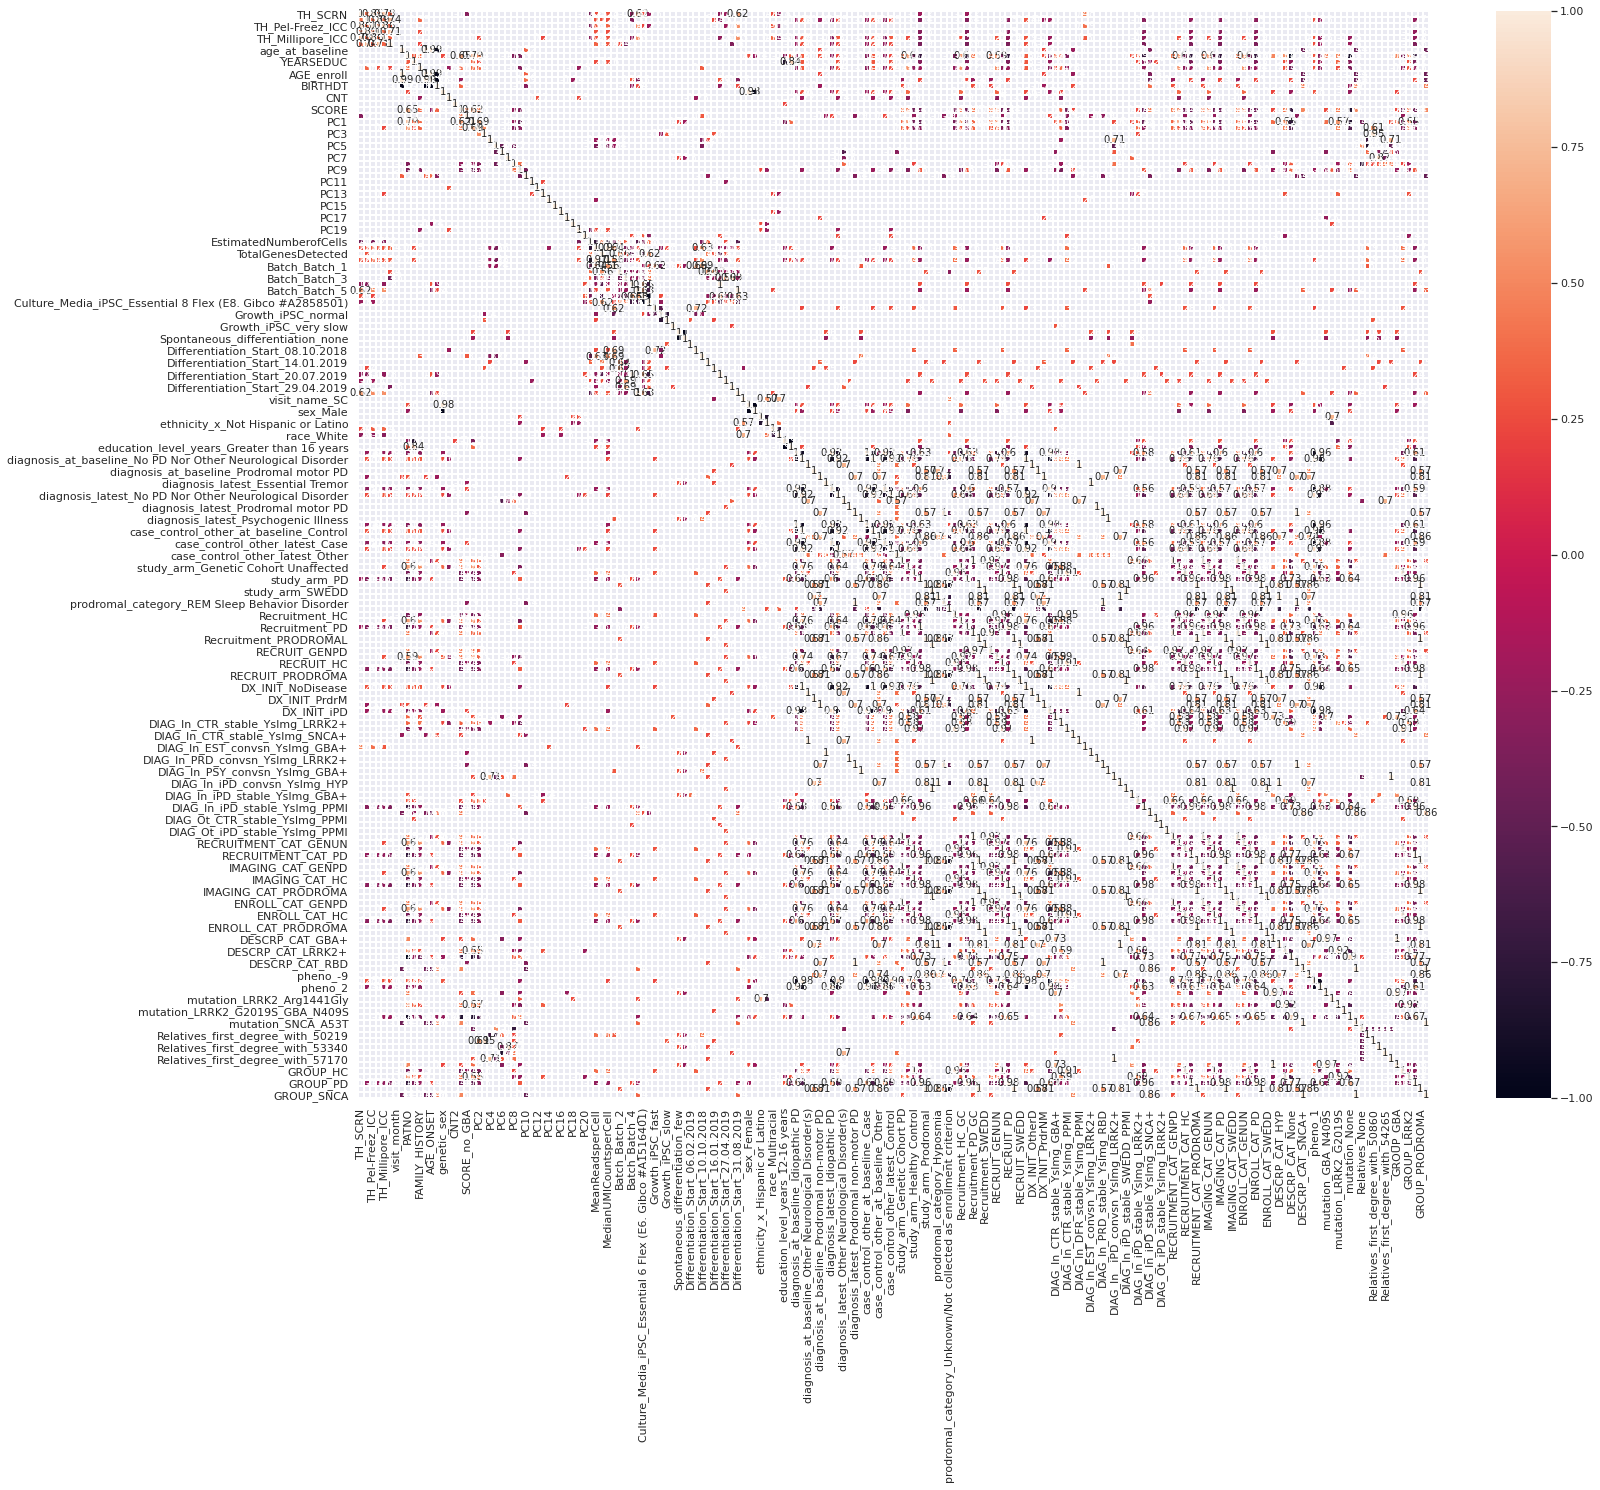

In [54]:
sns.set()
cor = covs_df.corr(method='pearson')
cor.dropna(how='all', inplace=True)
print(cor.shape)
plt.figure(figsize=(24,20))        
sns.heatmap(cor[(cor > 0.22) | (cor < -0.22)], annot=True, annot_kws={"fontsize":10}, \
            linewidths=0.05)
# sns.heatmap(cor[(cor > 0.1) | (cor < -0.1)], annot=True, annot_kws={"fontsize":12}, \
#             linewidths=0.05)
plt.show()